## Project Overview

In this notebook I build a binary classifier to distinguish simulated Higgs boson events from background noise using the public HIGGS dataset. I chose PyTorch specifically to gain hands-on experience with deep learning frameworks and develop a deeper understanding of end-to-end ML processes.

By building the neural network architecture and training loop from scratch, I learned how forward passes, backpropagation, gradient computation, and optimization work in practice. This project walks through a complete ML workflow:

- **Data loading and exploration (EDA)**
- **Feature preprocessing and scaling**
- **Logistic regression baseline**
- **Feed-forward neural network in PyTorch** (with custom training loop)
- **Hyperparameter tuning (learning rate sweep)**
- **Model evaluation with ROC curves and classification report**

The goal is not to beat state-of-the-art physics models, but to understand the mechanics of neural network training and demonstrate a production-ready ML workflow: clearly structured code, reusable functions, and interpretable metrics.

## 1. Setup and Imports

Here I import the core scientific Python stack (NumPy, Pandas, Matplotlib, Seaborn) along with PyTorch for the neural network and scikit-learn for preprocessing and the logistic regression baseline.

- **NumPy / Pandas**: data manipulation and loading the CSV.
- **Matplotlib / Seaborn**: plots for EDA and evaluation.
- **PyTorch**: building and training the neural network.
- **scikit-learn**: train/test split, scaling, baseline model, and metrics.

In [30]:
%matplotlib inline

# Core
import numpy as np
import pandas as pd
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Scikit-learn
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (roc_curve, auc, roc_auc_score, classification_report)

## 2. Compute Device (CPU vs GPU)

PyTorch can transparently run on either CPU or GPU.  
For this project, the HIGGS subset is small enough that CPU is sufficient, but I still detect `cuda` so the same code would work on a GPU-enabled environment without changes.

In [31]:
#make use of cpu for faster training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


## 3. Loading the HIGGS Dataset

I load a compressed CSV (`HIGGS.csv.gz`) containing simulated collision events.  
To keep training and experimentation fast, I limit myself to the first 1,000,000 rows:

- **`target`**: 1 = Higgs signal, 0 = background.
- **Features**: kinematic variables such as lepton/jet momenta, angles, and invariant masses.

If the file is missing, I explicitly raise an error with the absolute path to make debugging easier.

In [32]:
# Load in dataset
data_path = Path('HIGGS.csv.gz')
if not data_path.exists():
    raise FileNotFoundError(f'Dataset not found at {data_path.resolve()}')

# Creating Pandas dataframe with first 1 million rows in the Higgs dataset.
df = pd.read_csv(data_path, nrows=1_000_000, header=None)


## 4. Feature Naming

The raw CSV has no column names, so I assign the official feature labels from the HIGGS dataset paper.  
This makes downstream EDA and interpretation much clearer (e.g., seeing `lepton pT` instead of a generic `x3`).

In [33]:
# official feature names from the Higgs dataset paper.
feature_labels = ['target', 'lepton pT', 'lepton eta', 'lepton phi', 'missing energy magnitude',
 'missing energy phi', 'jet 1 pt', 'jet 1 eta', 'jet 1 phi', 'jet 1 b-tag',
 'jet 2 pt', 'jet 2 eta', 'jet 2 phi', 'jet 2 b-tag', 'jet 3 pt',
 'jet 3 eta', 'jet 3 phi', 'jet 3 b-tag', 'jet 4 pt', 'jet 4 eta',
 'jet 4 phi', 'jet 4 b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb',
 'm_wbb', 'm_wwbb']

# Apply names to the dataframe
df.columns = feature_labels
df.head()

,target,lepton pT,lepton eta,lepton phi,missing energy magnitude,missing energy phi,jet 1 pt,jet 1 eta,jet 1 phi,jet 1 b-tag,...,jet 4 eta,jet 4 phi,jet 4 b-tag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1.0,0.869293,-0.635082,0.225690,0.327470,-0.689993,0.754202,-0.248573,-1.092064,0.000000,...,-0.010455,-0.045767,3.101961,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,1.0,0.907542,0.329147,0.359412,1.497970,-0.313010,1.095531,-0.557525,-1.588230,2.173076,...,-1.138930,-0.000819,0.000000,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,1.0,0.798835,1.470639,-1.635975,0.453773,0.425629,1.104875,1.282322,1.381664,0.000000,...,1.128848,0.900461,0.000000,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.0,1.344385,-0.876626,0.935913,1.992050,0.882454,1.786066,-1.646778,-0.942383,0.000000,...,-0.678379,-1.360356,0.000000,0.946652,1.028704,0.998656,0.728281,0.869200,1.026736,0.957904
4,1.0,1.105009,0.321356,1.522401,0.882808,-1.205349,0.681466,-1.070464,-0.921871,0.000000,...,-0.373566,0.113041,0.000000,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487


## 5. Exploratory Data Analysis: Correlation Heatmap

As a first EDA step, I compute a Pearson correlation matrix across all features and visualize it with a heatmap.

- **Goal**: see which physics variables move together and identify highly correlated (possibly redundant) features.
- **Benefit**: builds intuition for the dataset and informs potential feature engineering or regularization choices later.

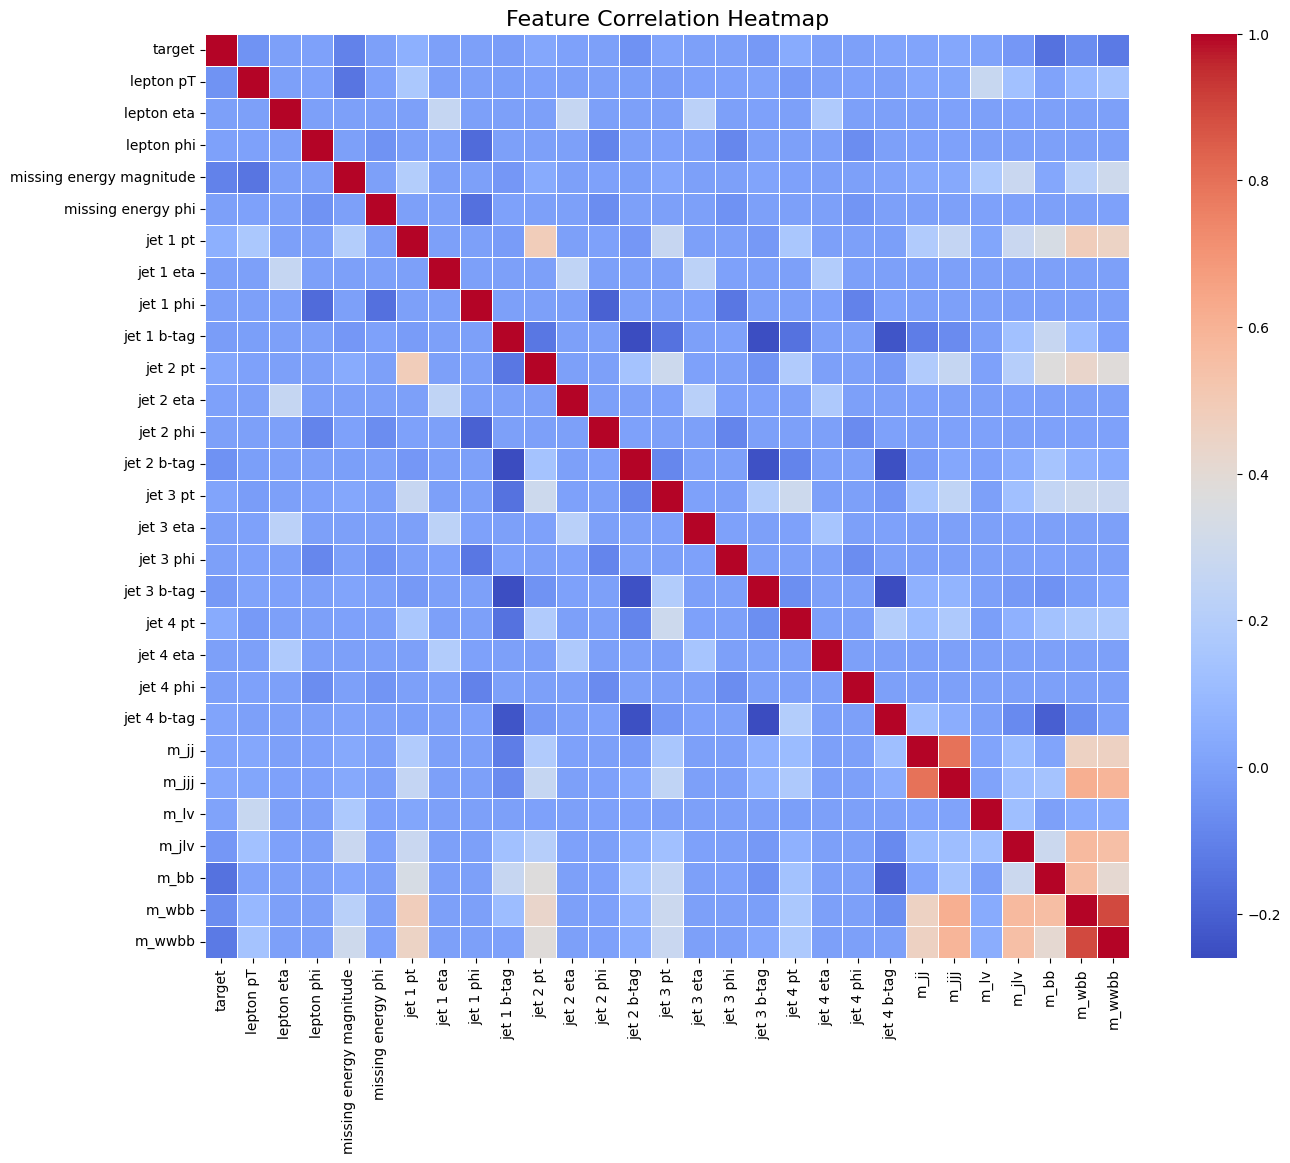

In [34]:
plt.figure(figsize=(16, 12))

# Compute correlation matrix
corr_matrix = df.corr()

# Plot the heatmap
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=False,    
    linewidths=0.5,
    square=True
)

plt.title("Feature Correlation Heatmap", fontsize=16)
plt.show()

## 6. Exploratory Data Analysis: Feature Distributions

Next, I plot histograms for each feature to understand their marginal distributions:

- Detect **skewness** and long tails (common in physical measurements).
- Check for **outliers** or strange artifacts.
- Verify that the `target` feature is roughly balanced after the 80/20 split.

This step helps justify scaling and informs model choice (e.g., logistic regression vs deeper networks).

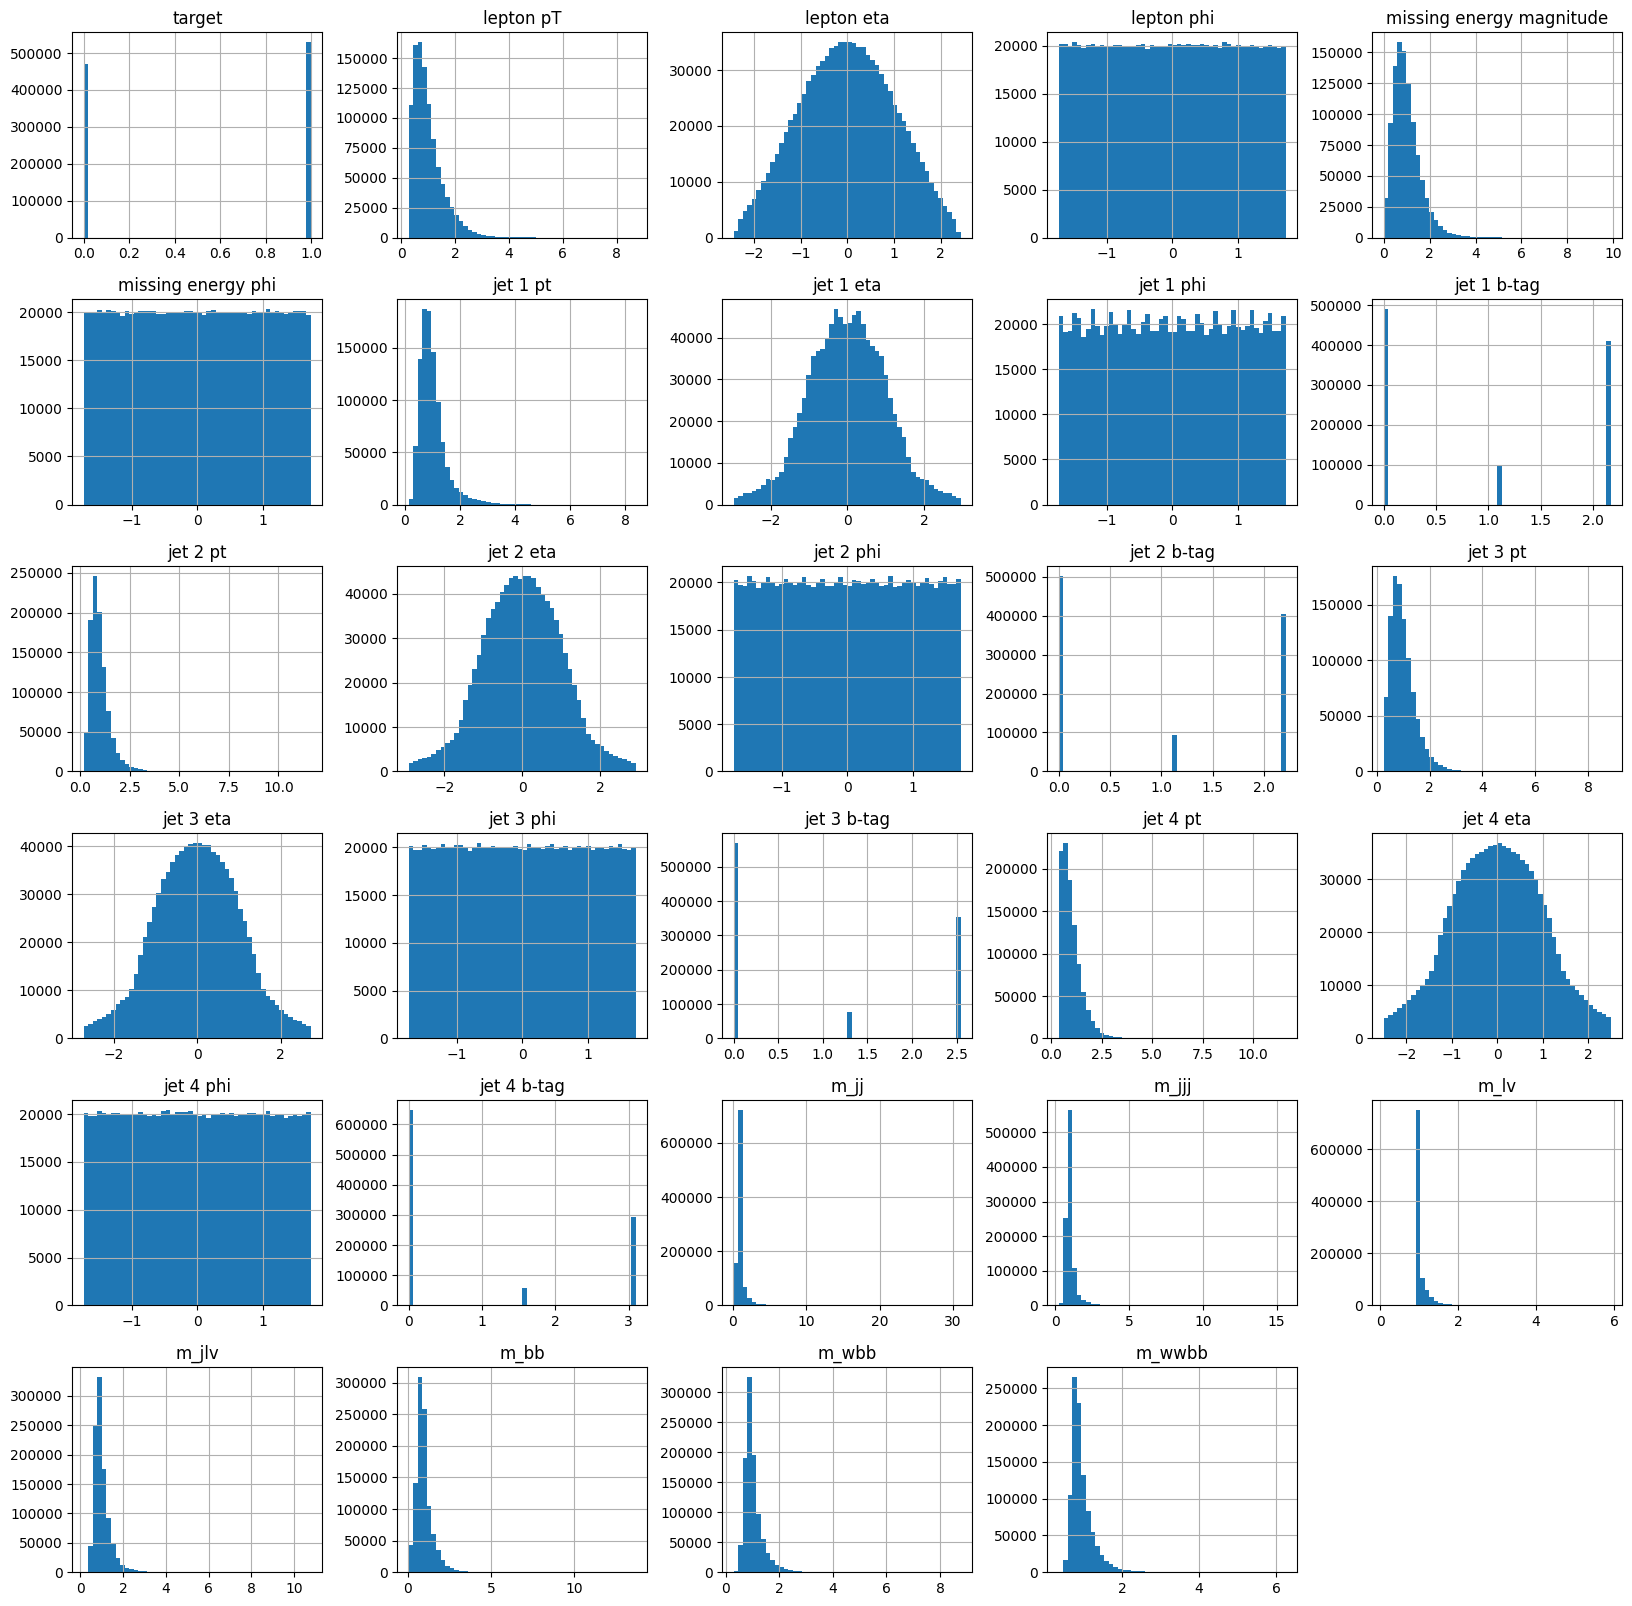

In [35]:
df.hist(figsize=(20, 20), bins=50);

## 7. Train/Validation/Test Split and Feature Scaling

I split the dataset into three disjoint sets to avoid data leakage:

- **Train (64%)**: used to fit model parameters (weights)
- **Validation (16%)**: used for hyperparameter tuning (e.g., learning rate) and model selection
- **Test (20%)**: used **once** for final evaluation after all choices are finalized

**Why this matters:** Using the test set during hyperparameter tuning is "peeking" at the answers and will produce overly optimistic performance. The validation set acts as the stand-in for unseen data during development, while the test set stays truly untouched until the end.

### Feature scaling (leakage-safe)
I standardize features with `StandardScaler`:

1. **Fit** the scaler on the **training features only** (`X_train`)
2. **Transform** `X_train`, `X_val`, and `X_test` using that same fitted scaler

This ensures statistics from validation/test data (means/variances) never influence training.


train: 640000 val: 160000 test: 200000
X_train_scaled rows vs y_train: 640000 640000


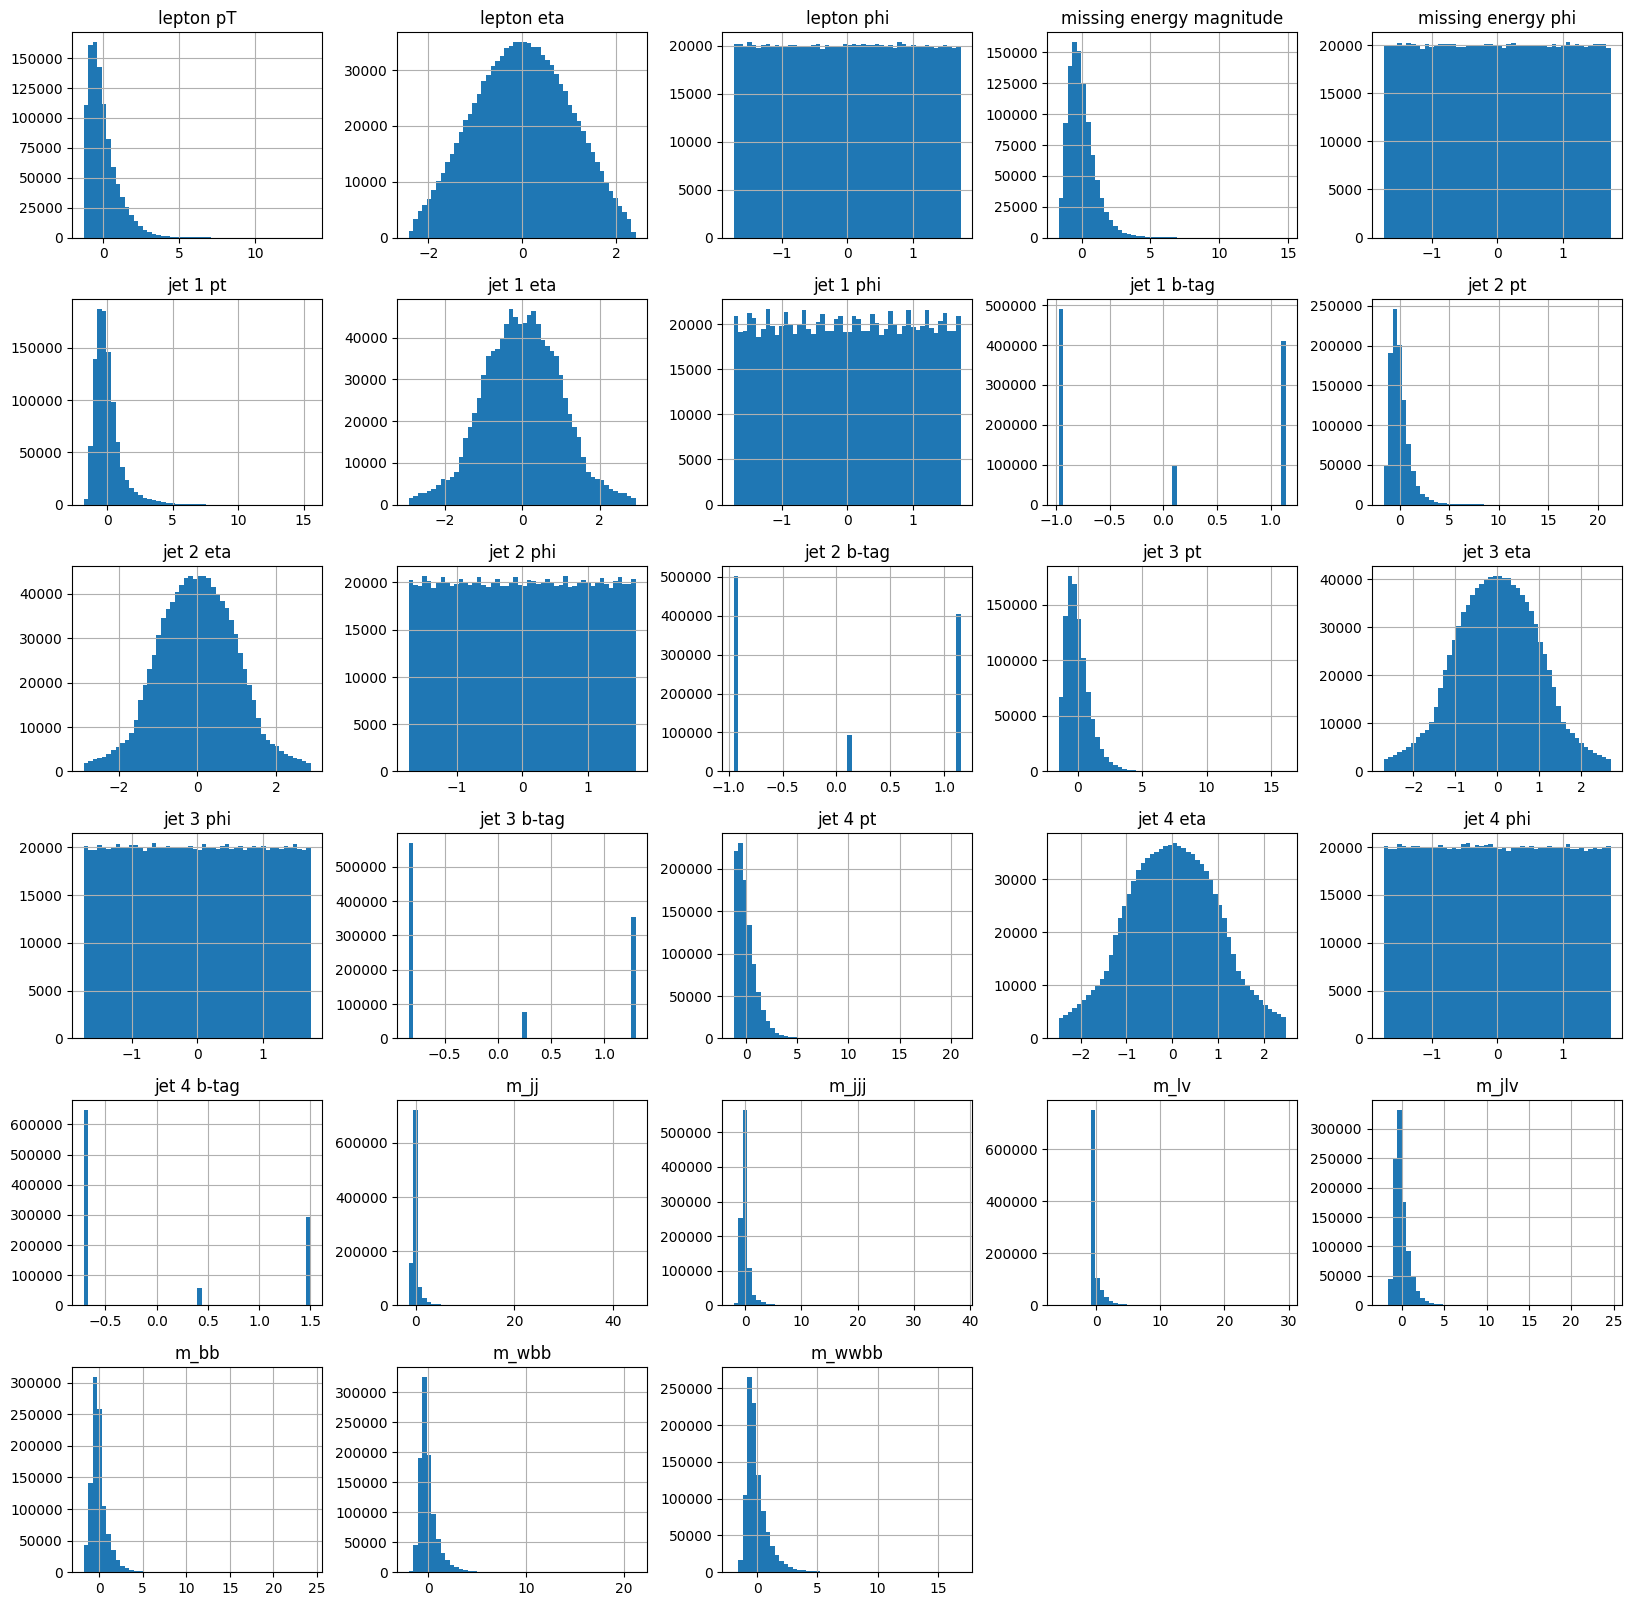

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch.utils.data import TensorDataset

# -----------------------------
# Split: Train/Val/Test
# -----------------------------
X = df.drop(columns=["target"])
y = df["target"]

X_trainval, X_test, y_trainval, y_test = train_test_split(
    X, y,
    test_size=0.20,
    random_state=37,
    stratify=y
)

X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval,
    test_size=0.20,          # 20% of 80% = 16% of total
    random_state=37,
    stratify=y_trainval
)

# -----------------------------
# Scale: fit on TRAIN only
# -----------------------------
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(X_train)
x_val_scaled   = scaler.transform(X_val)
x_test_scaled  = scaler.transform(X_test)

# -----------------------------
# PyTorch tensors/datasets
# -----------------------------
x_train_tensor = torch.tensor(x_train_scaled, dtype=torch.float32)
x_val_tensor   = torch.tensor(x_val_scaled,   dtype=torch.float32)
x_test_tensor  = torch.tensor(x_test_scaled,  dtype=torch.float32)

y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
y_val_tensor   = torch.tensor(y_val.values,   dtype=torch.float32)
y_test_tensor  = torch.tensor(y_test.values,  dtype=torch.float32)

xy_train = TensorDataset(x_train_tensor, y_train_tensor)
xy_val   = TensorDataset(x_val_tensor,   y_val_tensor)
xy_test  = TensorDataset(x_test_tensor,  y_test_tensor)

xy_trainval = TensorDataset(
    torch.cat([x_train_tensor, x_val_tensor], dim=0),
    torch.cat([y_train_tensor, y_val_tensor], dim=0)
)

print("train:", len(xy_train), "val:", len(xy_val), "test:", len(xy_test))

# -----------------------------
# ALSO: sklearn-friendly y (1D)
# -----------------------------
y_train_lr = y_train.values.ravel()
y_val_lr   = y_val.values.ravel()
y_test_lr  = y_test.values.ravel()

# quick sanity check (should all match)
print("X_train_scaled rows vs y_train:", x_train_scaled.shape[0], y_train_lr.shape[0])

# -----------------------------
# Optional: scaled DataFrame for histograms
# -----------------------------
df_scaled = X.copy()
df_scaled.loc[X_train.index, :] = x_train_scaled
df_scaled.loc[X_val.index,   :] = x_val_scaled
df_scaled.loc[X_test.index,  :] = x_test_scaled

df_scaled.hist(figsize=(20, 20), bins=50);

## 9. Logistic Regression Baseline

Before building a neural network, I establish a simple but strong baseline using scikit-learn’s `LogisticRegression`.

- Trained on the **scaled** features.
- Evaluated with **ROC AUC** on the held-out test set.
- The baseline AUC gives a concrete target: the neural network should clearly outperform this or it’s not worth the extra complexity.


In [40]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

log_reg = LogisticRegression(max_iter=200, solver="liblinear")
log_reg.fit(x_train_scaled, y_train_lr)

baseline_preds = log_reg.predict_proba(x_test_scaled)[:, 1]
baseline_auc = roc_auc_score(y_test_lr, baseline_preds)

print("Baseline Logistic Regression AUC:", baseline_auc)

Baseline Logistic Regression AUC: 0.6827618554216791


## 10. Neural Network Architecture (PyTorch)

Here I define a small fully-connected neural network using `nn.Sequential`:

- **Input layer (28 features) → 32 units → ReLU → Dropout(0.2)**
- **32 units → 16 units → ReLU → Dropout(0.2)**
- **16 units → 1 unit → Sigmoid**

The network is intentionally compact to balance **expressive power** and **overfitting risk**, and dropout adds additional regularization.


In [41]:
def build_model():
    model = nn.Sequential(
        nn.Linear(28, 32),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(32, 16),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(16, 1),
        nn.Sigmoid()
    ).to(device)

    return model

## 11. Training Loop and Evaluation (`learn` Function)

I encapsulate the full training process in a reusable `learn` function:

- Builds a `DataLoader` for mini-batch training.
- Uses **binary cross-entropy loss (BCELoss)** and **Adam** optimizer.
- Tracks **train** and **test** loss per epoch and optionally plots them to monitor convergence and overfitting.
- At the end, returns **loss curves**, **predicted probabilities** on the test set, and the **true labels**, which are later reused for ROC curves and classification metrics.

This abstraction makes it easy to experiment with different hyperparameters and architectures.


In [ ]:
torch.manual_seed(37)
def learn(train_data, test_data, model=build_model(), loss_fn=torch.nn.BCELoss(), n_epochs=20, batch_size=100000, learning_rate = 0.01, plot_losses=True):
    
    loader = torch.utils.data.DataLoader(train_data,batch_size=batch_size,shuffle=True)

    # move test tensors to device once
    x_test, y_test = test_data.tensors
    x_test = x_test.to(device)
    y_test = y_test.view(-1, 1).float().to(device)

    # optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    
    losses_train, losses_test = [], []

    for epoch in range(1, n_epochs + 1):
        model.train()
        running_loss = 0.0
        num_batches = 0

        for x_batch, y_batch in loader:
            x_batch = x_batch.to(device)
            y_batch = y_batch.view(-1, 1).float().to(device)

            optimizer.zero_grad()
            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            num_batches += 1

        avg_train_loss = running_loss / num_batches

        model.eval()
        with torch.no_grad():
            y_test_pred = model(x_test)
            test_loss = loss_fn(y_test_pred, y_test).item()

        losses_train.append(avg_train_loss)
        losses_test.append(test_loss)

        print(f"Epoch {epoch}/{n_epochs} | Train Loss: {avg_train_loss:.4f} | Test Loss: {test_loss:.4f}")
    
    if plot_losses:
        plt.figure(figsize=(8, 6))
        plt.plot(losses_train, label='TRAIN')
        plt.plot(losses_test, label='TEST')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Test Loss')
        plt.show()

    # final predictions on test set
    model.eval()
    with torch.no_grad():
        y_pred_test = model(x_test)
        y_pred_probs = y_pred_test.cpu().numpy().reshape(-1)

    y_true = y_test.cpu().numpy().reshape(-1)

    return losses_train, losses_test, y_pred_probs, y_true

## 12. Hyperparameter Tuning: Learning Rate Sweep

To choose a good learning rate, I perform a small sweep over several candidates (0.001, 0.01, 0.05, 0.1).

For each learning rate:

- Train the model for a fixed number of epochs.
- Compute **ROC AUC** on the test set.
- Store results in a DataFrame and sort by AUC.

This simple search helps find a stable learning rate that balances convergence speed and performance.



=== Training model with learning_rate = 0.001 ===
Epoch 1/20 | Train Loss: 0.7056 | Test Loss: 0.6999
Epoch 2/20 | Train Loss: 0.6981 | Test Loss: 0.6936
Epoch 3/20 | Train Loss: 0.6931 | Test Loss: 0.6890
Epoch 4/20 | Train Loss: 0.6890 | Test Loss: 0.6851
Epoch 5/20 | Train Loss: 0.6857 | Test Loss: 0.6815
Epoch 6/20 | Train Loss: 0.6823 | Test Loss: 0.6778
Epoch 7/20 | Train Loss: 0.6789 | Test Loss: 0.6738
Epoch 8/20 | Train Loss: 0.6751 | Test Loss: 0.6694
Epoch 9/20 | Train Loss: 0.6712 | Test Loss: 0.6647
Epoch 10/20 | Train Loss: 0.6671 | Test Loss: 0.6598
Epoch 11/20 | Train Loss: 0.6627 | Test Loss: 0.6548
Epoch 12/20 | Train Loss: 0.6583 | Test Loss: 0.6500
Epoch 13/20 | Train Loss: 0.6543 | Test Loss: 0.6455
Epoch 14/20 | Train Loss: 0.6505 | Test Loss: 0.6414
Epoch 15/20 | Train Loss: 0.6471 | Test Loss: 0.6380
Epoch 16/20 | Train Loss: 0.6440 | Test Loss: 0.6350
Epoch 17/20 | Train Loss: 0.6413 | Test Loss: 0.6324
Epoch 18/20 | Train Loss: 0.6394 | Test Loss: 0.6301
Epoc

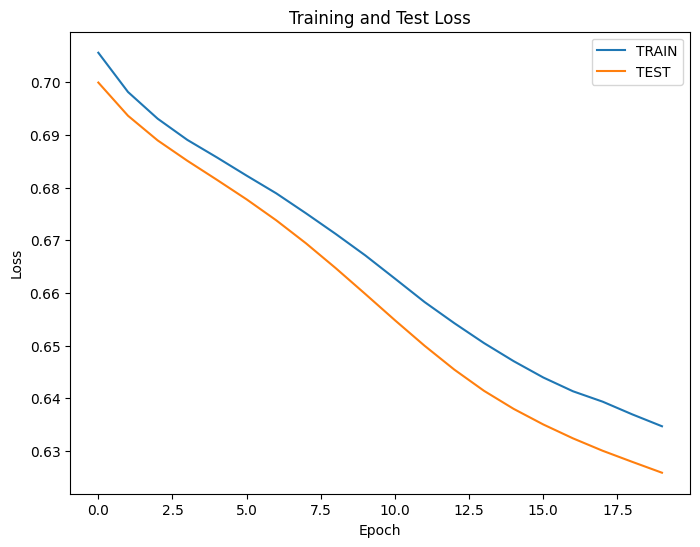

VAL AUC for lr=0.001: 0.7044

=== Training model with learning_rate = 0.01 ===
Epoch 1/20 | Train Loss: 0.6910 | Test Loss: 0.6738
Epoch 2/20 | Train Loss: 0.6675 | Test Loss: 0.6495
Epoch 3/20 | Train Loss: 0.6477 | Test Loss: 0.6319
Epoch 4/20 | Train Loss: 0.6354 | Test Loss: 0.6234
Epoch 5/20 | Train Loss: 0.6273 | Test Loss: 0.6150
Epoch 6/20 | Train Loss: 0.6201 | Test Loss: 0.6069
Epoch 7/20 | Train Loss: 0.6129 | Test Loss: 0.5990
Epoch 8/20 | Train Loss: 0.6068 | Test Loss: 0.5912
Epoch 9/20 | Train Loss: 0.5990 | Test Loss: 0.5825
Epoch 10/20 | Train Loss: 0.5906 | Test Loss: 0.5734
Epoch 11/20 | Train Loss: 0.5844 | Test Loss: 0.5684
Epoch 12/20 | Train Loss: 0.5790 | Test Loss: 0.5638
Epoch 13/20 | Train Loss: 0.5752 | Test Loss: 0.5598
Epoch 14/20 | Train Loss: 0.5718 | Test Loss: 0.5566
Epoch 15/20 | Train Loss: 0.5693 | Test Loss: 0.5542
Epoch 16/20 | Train Loss: 0.5668 | Test Loss: 0.5519
Epoch 17/20 | Train Loss: 0.5651 | Test Loss: 0.5499
Epoch 18/20 | Train Loss: 0.5

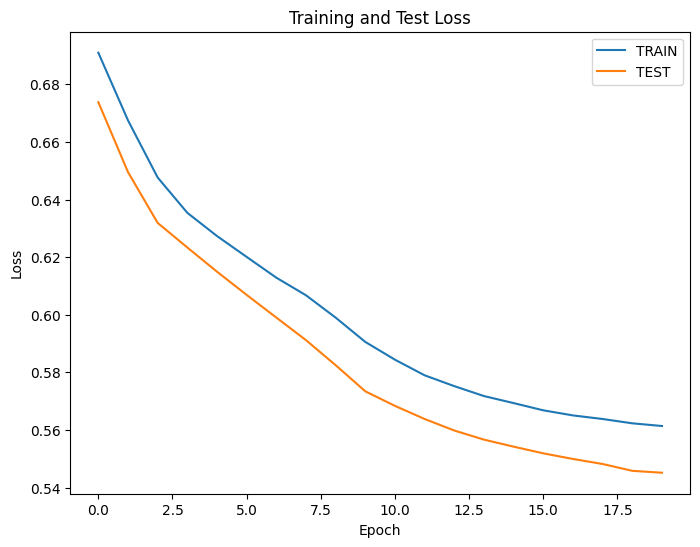

VAL AUC for lr=0.01: 0.7964

=== Training model with learning_rate = 0.05 ===
Epoch 1/20 | Train Loss: 0.6879 | Test Loss: 0.6547
Epoch 2/20 | Train Loss: 0.6510 | Test Loss: 0.6348
Epoch 3/20 | Train Loss: 0.6350 | Test Loss: 0.6181
Epoch 4/20 | Train Loss: 0.6245 | Test Loss: 0.6093
Epoch 5/20 | Train Loss: 0.6179 | Test Loss: 0.6018
Epoch 6/20 | Train Loss: 0.6094 | Test Loss: 0.5928
Epoch 7/20 | Train Loss: 0.6016 | Test Loss: 0.5817
Epoch 8/20 | Train Loss: 0.5936 | Test Loss: 0.5722
Epoch 9/20 | Train Loss: 0.5859 | Test Loss: 0.5665
Epoch 10/20 | Train Loss: 0.5807 | Test Loss: 0.5601
Epoch 11/20 | Train Loss: 0.5775 | Test Loss: 0.5604
Epoch 12/20 | Train Loss: 0.5741 | Test Loss: 0.5548
Epoch 13/20 | Train Loss: 0.5711 | Test Loss: 0.5511
Epoch 14/20 | Train Loss: 0.5679 | Test Loss: 0.5499
Epoch 15/20 | Train Loss: 0.5664 | Test Loss: 0.5490
Epoch 16/20 | Train Loss: 0.5651 | Test Loss: 0.5468
Epoch 17/20 | Train Loss: 0.5638 | Test Loss: 0.5445
Epoch 18/20 | Train Loss: 0.56

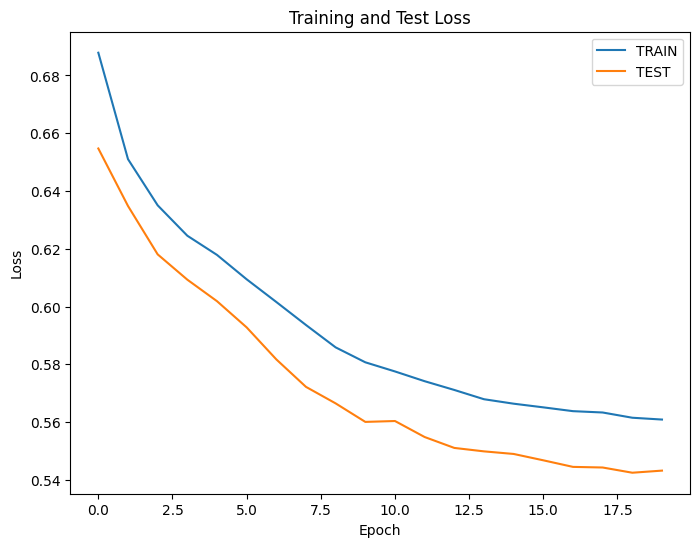

VAL AUC for lr=0.05: 0.7994

=== Training model with learning_rate = 0.1 ===
Epoch 1/20 | Train Loss: 0.7520 | Test Loss: 0.6972
Epoch 2/20 | Train Loss: 0.6871 | Test Loss: 0.6673
Epoch 3/20 | Train Loss: 0.6661 | Test Loss: 0.6481
Epoch 4/20 | Train Loss: 0.6554 | Test Loss: 0.6348
Epoch 5/20 | Train Loss: 0.6490 | Test Loss: 0.6269
Epoch 6/20 | Train Loss: 0.6437 | Test Loss: 0.6221
Epoch 7/20 | Train Loss: 0.6395 | Test Loss: 0.6200
Epoch 8/20 | Train Loss: 0.6363 | Test Loss: 0.6216
Epoch 9/20 | Train Loss: 0.6333 | Test Loss: 0.6108
Epoch 10/20 | Train Loss: 0.6292 | Test Loss: 0.6091
Epoch 11/20 | Train Loss: 0.6261 | Test Loss: 0.6050
Epoch 12/20 | Train Loss: 0.6235 | Test Loss: 0.5998
Epoch 13/20 | Train Loss: 0.6202 | Test Loss: 0.5969
Epoch 14/20 | Train Loss: 0.6175 | Test Loss: 0.5906
Epoch 15/20 | Train Loss: 0.6149 | Test Loss: 0.5881
Epoch 16/20 | Train Loss: 0.6135 | Test Loss: 0.5885
Epoch 17/20 | Train Loss: 0.6127 | Test Loss: 0.5864
Epoch 18/20 | Train Loss: 0.612

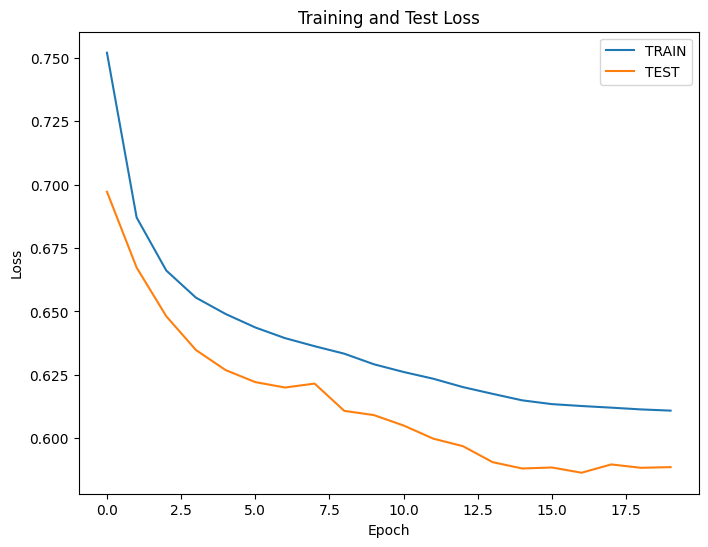

VAL AUC for lr=0.1: 0.7730


,learning_rate,val_auc
2,0.050,0.799430
1,0.010,0.796352
3,0.100,0.772966
0,0.001,0.704367


In [42]:
learning_rates = [0.001, 0.01, 0.05, 0.1]
results = []

for lr in learning_rates:
    print(f"\n=== Training model with learning_rate = {lr} ===")
    torch.manual_seed(37)
    model = build_model()

    # IMPORTANT: validate on xy_val
    losses_train, losses_val, y_pred_probs, y_true = learn(
        xy_train,
        xy_val,
        model=model,
        n_epochs=20,
        batch_size=100000,
        learning_rate=lr
    )

    auc_val = roc_auc_score(y_true, y_pred_probs)
    print(f"VAL AUC for lr={lr}: {auc_val:.4f}")

    results.append({"learning_rate": lr, "val_auc": auc_val})

results_df = pd.DataFrame(results).sort_values("val_auc", ascending=False)
results_df

## 13. Training the Final Model

After selecting the best learning rate from the sweep (here, `0.01`), I retrain a fresh model using that hyperparameter for more epochs.

- This run is dedicated to the **final model** whose outputs I will analyze.
- I keep the same train/test split and preprocessing to ensure that results are comparable with the baseline.

The function again returns predicted probabilities and true labels for downstream evaluation.


Epoch 1/30 | Train Loss: 0.6879 | Test Loss: 0.6545
Epoch 2/30 | Train Loss: 0.6510 | Test Loss: 0.6342
Epoch 3/30 | Train Loss: 0.6350 | Test Loss: 0.6181
Epoch 4/30 | Train Loss: 0.6245 | Test Loss: 0.6090
Epoch 5/30 | Train Loss: 0.6179 | Test Loss: 0.6017
Epoch 6/30 | Train Loss: 0.6094 | Test Loss: 0.5921
Epoch 7/30 | Train Loss: 0.6016 | Test Loss: 0.5809
Epoch 8/30 | Train Loss: 0.5936 | Test Loss: 0.5712
Epoch 9/30 | Train Loss: 0.5859 | Test Loss: 0.5657
Epoch 10/30 | Train Loss: 0.5807 | Test Loss: 0.5592
Epoch 11/30 | Train Loss: 0.5775 | Test Loss: 0.5593
Epoch 12/30 | Train Loss: 0.5741 | Test Loss: 0.5540
Epoch 13/30 | Train Loss: 0.5711 | Test Loss: 0.5504
Epoch 14/30 | Train Loss: 0.5679 | Test Loss: 0.5490
Epoch 15/30 | Train Loss: 0.5664 | Test Loss: 0.5484
Epoch 16/30 | Train Loss: 0.5651 | Test Loss: 0.5458
Epoch 17/30 | Train Loss: 0.5638 | Test Loss: 0.5436
Epoch 18/30 | Train Loss: 0.5633 | Test Loss: 0.5433
Epoch 19/30 | Train Loss: 0.5615 | Test Loss: 0.5417
Ep

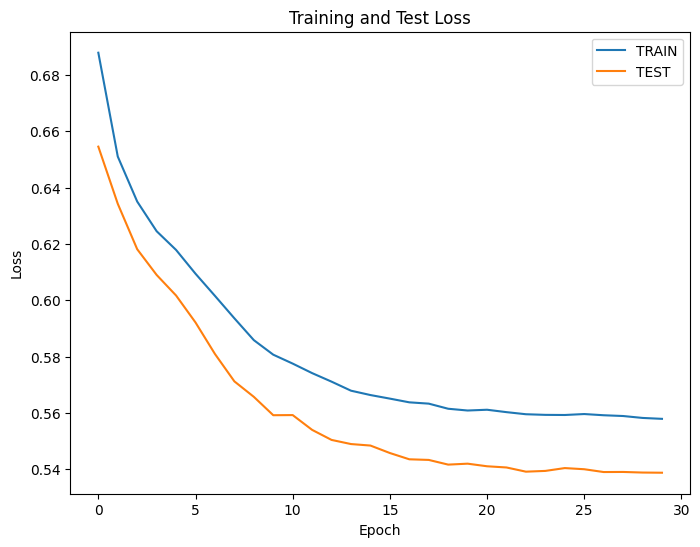

In [45]:
best_lr = 0.05  # best learning rate from the sweep

torch.manual_seed(37)
final_model = build_model()

losses_train, losses_test, y_pred_probs, y_true = learn(
    xy_train,
    xy_test,
    model=final_model,
    n_epochs=30,  
    batch_size=100000,
    learning_rate=best_lr,
    plot_losses=True
)

## 14. ROC Curve Comparison: Logistic Regression vs Neural Network

To compare the baseline and neural network more rigorously, I plot **ROC curves** for both models:

- Compute **FPR/TPR** pairs and **AUC** for:
  - Logistic regression baseline.
  - Final neural network.
- Include a **random guess** diagonal as a sanity check.

This visualization makes it easy to see if the neural network consistently dominates the baseline across different classification thresholds.


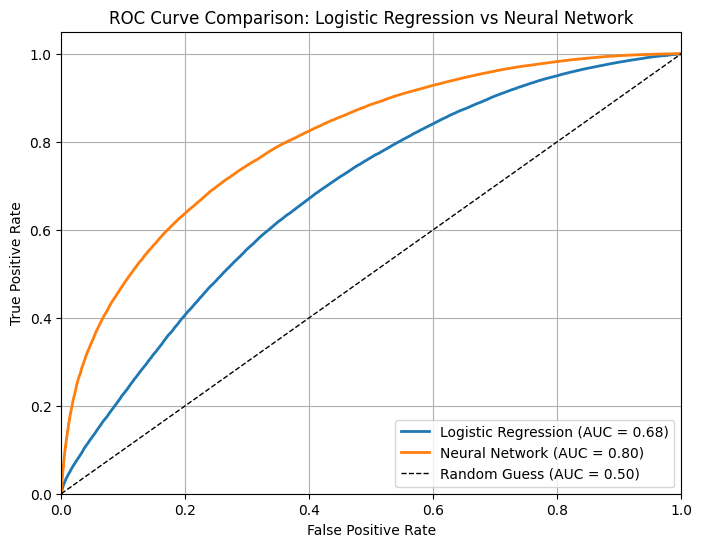

In [47]:

#ROC curve for our logistic regression baseline
fpr_log, tpr_log, _ = roc_curve(y_test, baseline_preds)
auc_log = auc(fpr_log, tpr_log)

#ROC curve for our neural net
fpr_nn, tpr_nn, _ = roc_curve(y_true, y_pred_probs)
auc_nn = auc(fpr_nn, tpr_nn)

# ----- Plot Both Curves -----
plt.figure(figsize=(8, 6))

# Logistic regression
plt.plot(
    fpr_log, tpr_log,
    lw=2,
    label=f'Logistic Regression (AUC = {auc_log:.2f})'
)

# Neural network
plt.plot(
    fpr_nn, tpr_nn,
    lw=2,
    linestyle='-',
    label=f'Neural Network (AUC = {auc_nn:.2f})'
)

# Random baseline
plt.plot([0, 1], [0, 1], 'k--', lw=1, label='Random Guess (AUC = 0.50)')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Logistic Regression vs Neural Network')
plt.legend(loc='lower right')
plt.grid(True)

plt.show()

## 15. Final Classification Report

Finally, I convert the neural network’s predicted probabilities into binary labels (threshold 0.5) and generate a detailed `classification_report`:

- **Precision, recall, F1-score** for both classes.
- **Support** (number of samples) per class.
- Overall **accuracy**, **macro**, and **weighted** averages.

Together with ROC AUC, this gives a well-rounded view of model performance and highlights the trade-off between correctly identifying Higgs events vs background.


In [48]:
y_pred_binary = (y_pred_probs >= 0.5).astype(int)
report = classification_report(y_true, y_pred_binary)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.71      0.69      0.70     94065
         1.0       0.73      0.75      0.74    105935

    accuracy                           0.72    200000
   macro avg       0.72      0.72      0.72    200000
weighted avg       0.72      0.72      0.72    200000



## 16. Summary and Future Work

In this project I built an end-to-end Higgs boson signal vs noise classifier, starting from raw CSV data and finishing with a regularized feed-forward neural net, evaluated via ROC curves and a detailed classification report. By choosing PyTorch and building the training loop from scratch, I gained hands-on experience with the mechanics of neural network training i.e., forward passes, backpropagation, gradient computation, and optimization deepening my understanding of how deep learning models actually work.

Along the way I: (1) performed basic EDA to understand feature correlations and distributions, (2) established a logistic regression baseline, and (3) designed and trained a regularized feed-forward neural network in PyTorch that improves on the baseline.

**Key takeaways**
- Building a custom training loop in PyTorch provided insight into how neural networks learn: seeing gradients flow backward, understanding how optimizers update weights, and monitoring train/test loss curves to detect overfitting.
- Careful preprocessing (standardization, consistent train/test splitting) and a clear baseline are crucial for interpreting neural network gains.
- Simple architectures with dropout and good hyperparameters can already achieve solid performance on large tabular datasets like HIGGS.
- Tracking both ROC AUC and per-class precision/recall helps understand trade-offs beyond a single accuracy number.

**Potential extensions (if continuing this project)**
This notebook demonstrates a complete ML workflow from data loading to model evaluation. If I were to extend this project further, I might explore:

- **More advanced architectures**: Try gradient boosting (XGBoost/LightGBM) or TabNet to see if they outperform the neural network on this tabular dataset.
- **More systematic hyperparameter search**: Use tools like Optuna to search across batch size, dropout rate, weight decay, and architecture choices more efficiently than manual sweeps.
- **Calibration and threshold optimization**: Apply Platt scaling or isotonic regression to improve probability calibration, and tune the classification threshold to optimize for specific physics objectives (e.g., maximize recall at a fixed false-positive rate).
- **Model interpretability**: Use SHAP values or feature importance methods to understand which physics variables drive the model's decisions, which could inform future feature engineering.